In [1]:
using ITensors

In [2]:
using Plots

In [3]:
using SparseArrays, LinearAlgebra, Arpack, LsqFit

# 1. J1-J2 spin 1/2 chain

##     1. Heisenberg Hamiltonian construction for finite J2 term

Using

$\vec{S_{i}\cdot}\vec{S}_{j}=S_{i}^{z}S_{j}^{z}+\frac{1}{2}(S_{i}^{+}S_{j}^{-}+S_{i}^{-}S_{j}^{+})$

The hamiltonian gets the form

$ H=J_{1}\sum_{i}\vec{S_{i}\cdot}\vec{S}_{i+1}+J_{2}\sum_{i}\vec{S_{i}}\cdot\vec{S_{i+2}}$

$    =J_{1}\sum_{i}\left(S_{i}^{z}S_{i+1}^{z}+\frac{1}{2}(S_{i}^{+}S_{i+1}^{-}+S_{i}^{-}S_{i+1}^{+})\right)+J_{2}\sum_{i}\left(S_{i}^{z}S_{i+2}^{z}+\frac{1}{2}(S_{i}^{+}S_{i+2}^{-}+S_{i}^{-}S_{i+2}^{+})\right) $

Generalization of the method seen in class 6 for the MPO will lead to the matrices


$W_{(L)}=\left(\begin{array}{c}
I\\
S^{z}\\
S^{+}\\
S^{-}\\
0\\
0\\
0\\
0
\end{array}\right)$

$W_{(i)}=\left(\begin{array}{cccccccc}
I & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
S^{z} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
S^{+} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
S^{-} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & I & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & I & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & I & 0 & 0 & 0 & 0\\
0 & J_{1}S^{z} & \frac{J_{1}}{2}S^{-} & \frac{J_{1}}{2}S^{+} & J_{2}S^{z} & \frac{J_{2}}{2}S^{-} & \frac{J_{2}}{2}S^{+} & I
\end{array}\right)$

$W_{(1)}=\left(\begin{array}{cccccccc}
0 & J_{1}S^{z} & \frac{J_{1}}{2}S^{-} & \frac{J_{1}}{2}S^{+} & J_{2}S^{z} & \frac{J_{2}}{2}S^{-} & \frac{J_{2}}{2}S^{+} & I\end{array}\right)$

In [5]:
function J1J2_DMRG(N::Int64, J1::Float64, J2::Float64, swp_num::Int64, maxM::Int64, QN_subspace::Int64)
    
    # Generate an index set representing quantum sites with spin S=1/2
    sites = siteinds("S=1/2", N; conserve_qns=true)

    # Initialize an operator sum representing the Hamiltonian using ITensors
    ampo = OpSum()

    # Construct the Hamiltonian operator for the TFIM
    for j = 1:N
        if j < N
            # Interaction term between neighboring spins (Sz-Sz)
            ampo += J1, "Sz", j, "Sz", j + 1
            ampo += J1/2, "S+", j, "S-", j + 1 
            ampo += J1/2, "S-", j, "S+", j + 1
        end
        if j < N-1
            # Interaction term between second neighboring spins (Sz-Sz)
            ampo += J2, "Sz", j, "Sz", j + 2
            ampo += J2/2, "S+", j, "S-", j + 2 
            ampo += J2/2, "S-", j, "S+", j + 2
        end 
    end

    # Convert the operator sum to a Matrix Product Operator (MPO)
    H = MPO(ampo, sites)

    # Initialize the initial state to a random maxM=10 state 
    #psi0 = randomMPS(sites,10)
    state= [isodd(n) ? "Up" : "Dn" for n=1:N]
    if QN_subspace == 1
        state[2]="Up"
    end
    psi0 = MPS(sites,state)
    
    # Set up parameters for the DMRG (Density Matrix Renormalization Group) algorithm
    sweeps = Sweeps(swp_num)
    setmaxdim!(sweeps, maxM)
    setcutoff!(sweeps, 1E-16)

    # Perform the DMRG simulation to obtain the ground state energy and MPS representation
    energy, psi = dmrg(H, psi0, sweeps);

    return energy, psi
end;

## 2. Finite size scaling

In [6]:
function energy_gap_calc(H_func,N_arr,g,swp_num,maxM,base_subspace=0,excited_subspace=1 ; return_states = false)
    delta_arr=[]
    psi_0_arr=[]
    psi_excited_arr=[]
    J1=1.
    J2=g*J1
    for N in N_arr
        energy_s0, psi_0 = H_func(N, J1, J2, swp_num, maxM,base_subspace);
        energy_s_excited, psi_excited = H_func(N, J1, J2, swp_num, maxM,excited_subspace);
        push!(delta_arr, energy_s_excited-energy_s0)
        push!(psi_0_arr,psi_0)
        push!(psi_excited_arr,psi_excited)
    end
    if !return_states
        return delta_arr
    else
        return delta_arr, psi_0_arr, psi_excited_arr
    end
end;

In [9]:
N_arr= [ n for n in 20:20:100];
swp_num = 10
maxM = 100
g_arr=[0 ,0.241, 0.48];

In [10]:
j1j2spin_half_deltas_arr=[]
for g in g_arr
    push!(j1j2spin_half_deltas_arr,energy_gap_calc(J1J2_DMRG,N_arr,g,swp_num,maxM))
end;

After sweep 1 energy=-8.60514183065435  maxlinkdim=4 maxerr=0.00E+00 time=42.475
After sweep 2 energy=-8.681922609869904  maxlinkdim=16 maxerr=0.00E+00 time=1.500
After sweep 3 energy=-8.682473323653621  maxlinkdim=64 maxerr=8.77E-17 time=0.665
After sweep 4 energy=-8.68247333439891  maxlinkdim=99 maxerr=9.81E-17 time=0.215
After sweep 5 energy=-8.682473334398972  maxlinkdim=97 maxerr=1.04E-16 time=0.260
After sweep 6 energy=-8.682473334398976  maxlinkdim=97 maxerr=8.94E-17 time=0.282
After sweep 7 energy=-8.682473334398955  maxlinkdim=97 maxerr=8.94E-17 time=0.270
After sweep 8 energy=-8.682473334398965  maxlinkdim=97 maxerr=8.94E-17 time=0.312
After sweep 9 energy=-8.682473334398964  maxlinkdim=97 maxerr=8.94E-17 time=0.284
After sweep 10 energy=-8.68247333439896  maxlinkdim=97 maxerr=8.94E-17 time=0.248
After sweep 1 energy=-7.910060820117726  maxlinkdim=4 maxerr=0.00E+00 time=0.044
After sweep 2 energy=-8.479555924186457  maxlinkdim=16 maxerr=0.00E+00 time=0.117
After sweep 3 energ

After sweep 10 energy=-44.08729916754671  maxlinkdim=100 maxerr=1.76E-10 time=3.669
After sweep 1 energy=-7.893031868110662  maxlinkdim=4 maxerr=0.00E+00 time=0.306
After sweep 2 energy=-7.94944575912862  maxlinkdim=16 maxerr=0.00E+00 time=0.271
After sweep 3 energy=-7.94978613502113  maxlinkdim=64 maxerr=9.98E-17 time=0.325
After sweep 4 energy=-7.949786241657115  maxlinkdim=100 maxerr=6.60E-16 time=1.027
After sweep 5 energy=-7.949786241662649  maxlinkdim=100 maxerr=2.41E-16 time=0.805
After sweep 6 energy=-7.949786241662642  maxlinkdim=100 maxerr=1.70E-16 time=0.706
After sweep 7 energy=-7.949786241662626  maxlinkdim=100 maxerr=1.70E-16 time=0.934
After sweep 8 energy=-7.949786241662648  maxlinkdim=100 maxerr=1.70E-16 time=0.895
After sweep 9 energy=-7.949786241662641  maxlinkdim=100 maxerr=1.70E-16 time=0.974
After sweep 10 energy=-7.949786241662631  maxlinkdim=100 maxerr=1.70E-16 time=0.630
After sweep 1 energy=-7.267425336676245  maxlinkdim=4 maxerr=0.00E+00 time=0.091
After swee

After sweep 9 energy=-40.06545406548293  maxlinkdim=100 maxerr=8.84E-11 time=6.483
After sweep 10 energy=-40.06553217396506  maxlinkdim=100 maxerr=5.58E-11 time=7.852
After sweep 1 energy=-7.49616712208073  maxlinkdim=4 maxerr=0.00E+00 time=0.133
After sweep 2 energy=-7.503861902049232  maxlinkdim=16 maxerr=0.00E+00 time=0.391
After sweep 3 energy=-7.503869774420087  maxlinkdim=64 maxerr=7.84E-17 time=0.345
After sweep 4 energy=-7.503869788818607  maxlinkdim=100 maxerr=3.64E-16 time=0.514
After sweep 5 energy=-7.503869788823641  maxlinkdim=91 maxerr=2.01E-16 time=0.675
After sweep 6 energy=-7.503869788823639  maxlinkdim=86 maxerr=9.98E-17 time=0.446
After sweep 7 energy=-7.503869788823646  maxlinkdim=86 maxerr=9.94E-17 time=0.522
After sweep 8 energy=-7.503869788823656  maxlinkdim=86 maxerr=9.94E-17 time=0.660
After sweep 9 energy=-7.503869788823648  maxlinkdim=86 maxerr=9.94E-17 time=0.452
After sweep 10 energy=-7.503869788823638  maxlinkdim=86 maxerr=9.94E-17 time=0.510
After sweep 1

After sweep 8 energy=-37.30391943337031  maxlinkdim=100 maxerr=4.45E-11 time=5.096
After sweep 9 energy=-37.30837316989935  maxlinkdim=100 maxerr=6.28E-11 time=5.646
After sweep 10 energy=-37.31212928522433  maxlinkdim=100 maxerr=8.88E-11 time=6.579


In [11]:
function plot_delta_energies(deltas,N_array,g; plot_fit=true)
    x = 1 ./ N_array
    fun(x, a) = a[1] .+ a[2]*x
    res = LsqFit.curve_fit(fun, x, deltas, [0., 0.]);
    plt=scatter(x, deltas,linestyle = :dot,title="Energy deltas g=$g",xlabel="1/N",ylabel= "Delta")
    if plot_fit
        plot!(plt,x, fun(x, coef(res)))
        intercept=coef(res)[1]
        println("The intercept for g=0 is $intercept")
    end
    return plt
end;

For g=0:

The intercept for g=0 is 0.006985882985487524


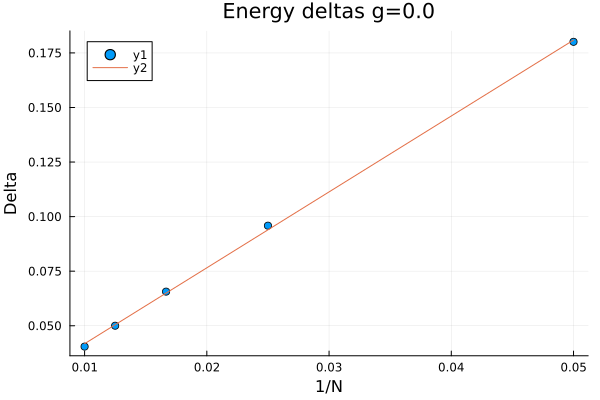

In [12]:
i=1
plot_delta_energies(j1j2spin_half_deltas_arr[i],N_arr,g_arr[i])

Which is pretty close to zero, indicating the system is gapless as expected

For g=g_c=0.241

The intercept for g=0 is 0.003511926213340998


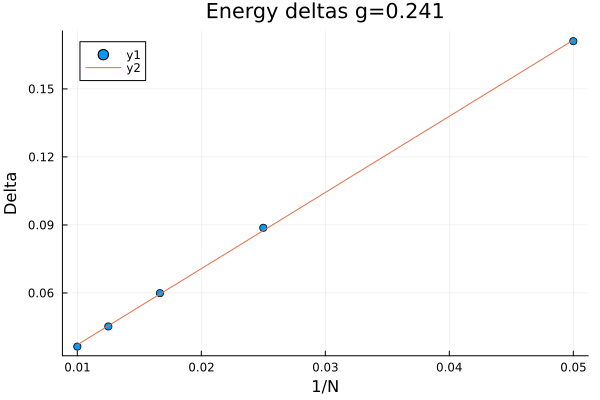

In [13]:
i=2
plot_delta_energies(j1j2spin_half_deltas_arr[i],N_arr,g_arr[i])

Which is pretty close to zero, indicating the system is gapless as expected for still being in the phase with g below gc

For g=0.48:

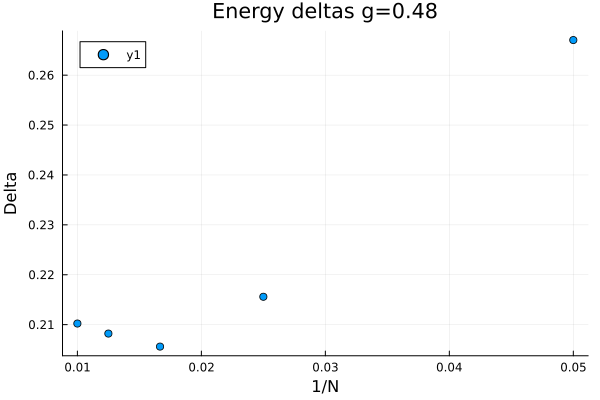

In [14]:
i=3
plot_delta_energies(j1j2spin_half_deltas_arr[i],N_arr,g_arr[i],plot_fit=false)

Here we can see an obvious finite gap as expected from being deep in the dimerized phase. The trend of the points indicates an intercept with the y axis which is non-zero.

## 3. Spin-spin correlations

In [15]:
function plot_SzSz_correlations(corr_mat, x_array, g , plot_fit_type="power_law")
    N = x_array[end]
    
    """
    #x = x_array[100:end] .- 100
    #y= log10.(abs.(corr_mat[100,100:end]))
    x = 1 ./ (x_array[101:end] .- 100)
    y = abs.(corr_mat[100,101:end])
    """
    x = x_array[101:end] .- 100
    y = abs.(corr_mat[100,101:end])
    plt=scatter(x,y,xlabel="x-100",ylabel="Sₓ₀⃗⋅Sₓ⃗",title="Spin correlations for g=$g",label="correlations")
    if plot_fit_type=="power_law"
        fun_power(x, a) = a[1] ./ (x .^ a[2])
        res = LsqFit.curve_fit(fun_power, x, y, [100.,1.]);
        plot!(x , fun_power(x, coef(res)),label="fit")
        α_g=coef(res)[2]
        println("The exponent α for g=$g was found from the fit to be $α_g")
    end
    if plot_fit_type=="exp_law"
        fun_exp(x, a) = a[1]*exp.(-x./a[2])
        res = LsqFit.curve_fit(fun_exp, x, y, [0.,1.]);
        plot!(x , fun_exp(x, coef(res)),label="fit")
        α_g=coef(res)[2]
        println("The correlation length for g=$g was found from the fit to be $α_g")
    end
    return plt
end;

In [16]:
N = 200
x_array= [x for x in 1:N];
swp_num = 10
maxM = 100
J1=1.0;
g_array=[0 ,0.241, 0.48];

In [17]:
corr_mats=[]
for g in g_array
    energy, psi = J1J2_DMRG(N,1., g, swp_num, maxM ,0)
    push!(corr_mats, correlation_matrix(psi,"Sz","Sz"))
end

After sweep 1 energy=-87.90732132925154  maxlinkdim=4 maxerr=0.00E+00 time=0.596
After sweep 2 energy=-88.40009736494895  maxlinkdim=16 maxerr=0.00E+00 time=1.413
After sweep 3 energy=-88.4367923683276  maxlinkdim=64 maxerr=9.54E-17 time=2.236
After sweep 4 energy=-88.44026222450567  maxlinkdim=100 maxerr=3.54E-11 time=4.704
After sweep 5 energy=-88.4412149980951  maxlinkdim=100 maxerr=3.27E-10 time=6.100
After sweep 6 energy=-88.44152457900702  maxlinkdim=100 maxerr=2.73E-09 time=8.694
After sweep 7 energy=-88.44155419065386  maxlinkdim=100 maxerr=3.52E-09 time=6.607
After sweep 8 energy=-88.44155471067545  maxlinkdim=100 maxerr=2.85E-09 time=6.162
After sweep 9 energy=-88.44155471372999  maxlinkdim=100 maxerr=2.80E-09 time=7.483
After sweep 10 energy=-88.44155471369858  maxlinkdim=100 maxerr=2.81E-09 time=6.883
After sweep 1 energy=-79.85921543022567  maxlinkdim=4 maxerr=0.00E+00 time=0.933
After sweep 2 energy=-80.26699841583698  maxlinkdim=16 maxerr=0.00E+00 time=2.155
After sweep 

For g=0:

The exponent α for g=0.0 was found from the fit to be 0.9747021126405984


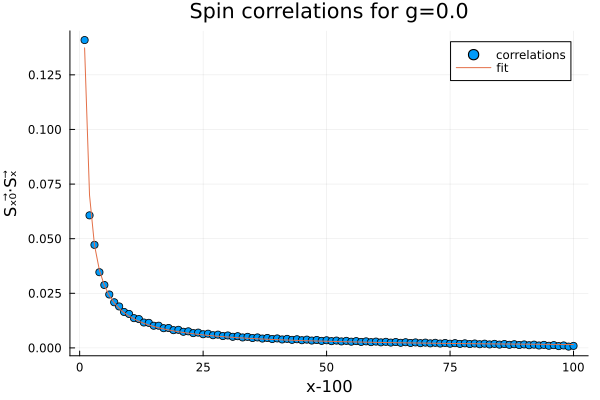

In [18]:
i=1
plt=plot_SzSz_correlations(corr_mats[i], x_array, g_array[i])

For g=g_c=0.241

The exponent α for g=0.241 was found from the fit to be 1.1334176605526294


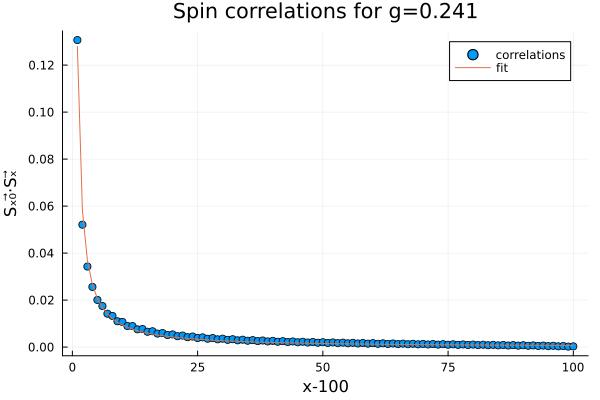

In [19]:
i=2
plot_SzSz_correlations(corr_mats[i], x_array, g_array[i])

For g=0.48:

The correlation length for g=0.48 was found from the fit to be 1.8987928552306337


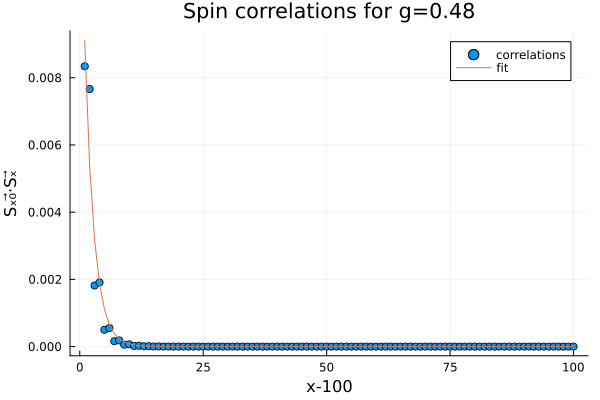

In [20]:
i=3
plot_SzSz_correlations(corr_mats[i], x_array, g_array[i],"exp_law")

# 2. spin-1 - Haldane gap

In [21]:
function bilinear_biquadtatic_DMRG(N::Int64, J1::Float64, J2::Float64, swp_num::Int64, maxM::Int64, QN_subspace::Int64)
    
    # Generate an index set representing quantum sites with spin S=1/2
    sites = siteinds("S=1", N; conserve_qns=true)

    # Initialize an operator sum representing the Hamiltonian using ITensors
    ampo = OpSum()

    # Construct the Hamiltonian operator for the TFIM
    for j = 1:N-1
        # Interaction term between neighboring spins (Sz-Sz)
        ampo += J1, "Sz", j, "Sz", j + 1
        ampo += J1/2, "S+", j, "S-", j + 1
        ampo += J1/2, "S-", j, "S+", j + 1
        
        #J2 
        ampo += J2, "Sz", j, "Sz", j + 1, "Sz", j, "Sz", j + 1
        ampo += J2/4, "S+", j, "S-", j + 1, "S-", j, "S+", j + 1
        ampo += J2/4, "S-", j, "S+", j + 1, "S+", j, "S-", j + 1
        ampo += J2/4, "S+", j, "S-", j + 1, "S+", j, "S-", j + 1
        ampo += J2/4, "S-", j, "S+", j + 1, "S-", j, "S+", j + 1
        ampo += J2/2, "S-", j, "S+", j + 1, "Sz", j, "Sz", j + 1
        ampo += J2/2, "S+", j, "S-", j + 1, "Sz", j, "Sz", j + 1
        ampo += J2/2, "Sz", j, "Sz", j + 1, "S-", j, "S+", j + 1
        ampo += J2/2, "Sz", j, "Sz", j + 1, "S+", j, "S-", j + 1
    end

    # Convert the operator sum to a Matrix Product Operator (MPO)
    H = MPO(ampo, sites)

    # Initialize the initial state to a random maxM=10 state 
    # psi0 = randomMPS(sites,10)
    state= [isodd(n) ? "Up" : "Dn" for n=1:N]
    if QN_subspace == 1
        state[2]="0"
    end
    if QN_subspace == 2
        state[2]="Up"
    end
    psi0 = MPS(sites,state)
    # Set up parameters for the DMRG (Density Matrix Renormalization Group) algorithm
    sweeps = Sweeps(swp_num)
    setmaxdim!(sweeps, maxM)
    setcutoff!(sweeps, 1E-16)

    # Perform the DMRG simulation to obtain the ground state energy and MPS representation
    energy, psi = dmrg(H, psi0, sweeps)

    return energy, psi
end;

## 1. System gap for J2 between 0 and 1/3

In [22]:
N_arr= [ n for n in 20:20:100];
swp_num = 10
maxM = 100;

In [23]:
J2_arr=[ j for j in 0:1/12:1/3];

In [24]:
deltas_arr=[]
for g in J2_arr
    push!(deltas_arr,energy_gap_calc(bilinear_biquadtatic_DMRG,N_arr,g,swp_num,maxM,0,2))
end;

After sweep 1 energy=-26.75638798881602  maxlinkdim=9 maxerr=0.00E+00 time=0.591
After sweep 2 energy=-26.828056595029913  maxlinkdim=79 maxerr=8.78E-17 time=0.539
After sweep 3 energy=-26.83029331381671  maxlinkdim=100 maxerr=5.16E-10 time=0.852
After sweep 4 energy=-26.833623190738706  maxlinkdim=100 maxerr=1.05E-09 time=0.758
After sweep 5 energy=-26.83753390916417  maxlinkdim=100 maxerr=2.34E-09 time=0.932
After sweep 6 energy=-26.839437495110868  maxlinkdim=100 maxerr=2.69E-09 time=0.789
After sweep 7 energy=-26.839907332615596  maxlinkdim=100 maxerr=3.74E-09 time=0.819
After sweep 8 energy=-26.839972031795604  maxlinkdim=100 maxerr=5.91E-09 time=0.736
After sweep 9 energy=-26.83997807919772  maxlinkdim=100 maxerr=2.27E-09 time=0.762
After sweep 10 energy=-26.839978567153093  maxlinkdim=100 maxerr=7.26E-10 time=0.841
After sweep 1 energy=-24.148917750350922  maxlinkdim=9 maxerr=0.00E+00 time=0.090
After sweep 2 energy=-26.119141743021096  maxlinkdim=81 maxerr=9.43E-17 time=0.353
A

After sweep 10 energy=-138.50434294406858  maxlinkdim=100 maxerr=2.59E-09 time=6.033
After sweep 1 energy=-22.998796096796468  maxlinkdim=9 maxerr=0.00E+00 time=0.116
After sweep 2 energy=-23.046826549391092  maxlinkdim=78 maxerr=9.31E-17 time=0.549
After sweep 3 energy=-23.047100886268854  maxlinkdim=100 maxerr=8.25E-11 time=1.245
After sweep 4 energy=-23.047442836572483  maxlinkdim=100 maxerr=1.45E-10 time=1.356
After sweep 5 energy=-23.048123180033038  maxlinkdim=100 maxerr=2.27E-10 time=1.289
After sweep 6 energy=-23.049263654809963  maxlinkdim=100 maxerr=3.23E-10 time=1.426
After sweep 7 energy=-23.05039129550728  maxlinkdim=100 maxerr=5.89E-10 time=1.245
After sweep 8 energy=-23.05093750671484  maxlinkdim=100 maxerr=5.20E-10 time=1.493
After sweep 9 energy=-23.05107585292633  maxlinkdim=100 maxerr=3.37E-10 time=1.319
After sweep 10 energy=-23.0511018183303  maxlinkdim=100 maxerr=3.09E-10 time=1.436
After sweep 1 energy=-20.567636370164994  maxlinkdim=9 maxerr=0.00E+00 time=0.243


After sweep 9 energy=-119.07561608387283  maxlinkdim=100 maxerr=1.70E-10 time=9.534
After sweep 10 energy=-119.0828542872625  maxlinkdim=100 maxerr=6.79E-10 time=9.844
After sweep 1 energy=-19.383915149749974  maxlinkdim=9 maxerr=0.00E+00 time=0.137
After sweep 2 energy=-19.409761192481984  maxlinkdim=78 maxerr=9.99E-17 time=0.546
After sweep 3 energy=-19.4097848632376  maxlinkdim=100 maxerr=2.79E-12 time=1.169
After sweep 4 energy=-19.40979438748053  maxlinkdim=100 maxerr=5.34E-12 time=1.504
After sweep 5 energy=-19.409809982056814  maxlinkdim=100 maxerr=8.13E-12 time=1.634
After sweep 6 energy=-19.40984191331785  maxlinkdim=100 maxerr=1.24E-11 time=1.477
After sweep 7 energy=-19.40991437919027  maxlinkdim=100 maxerr=1.59E-11 time=1.391
After sweep 8 energy=-19.41000866031231  maxlinkdim=100 maxerr=2.67E-11 time=1.467
After sweep 9 energy=-19.410101724787808  maxlinkdim=100 maxerr=3.10E-11 time=1.338
After sweep 10 energy=-19.410186974204105  maxlinkdim=100 maxerr=3.43E-11 time=1.431


After sweep 8 energy=-99.73113281283425  maxlinkdim=100 maxerr=1.04E-09 time=9.914
After sweep 9 energy=-100.32563743464551  maxlinkdim=100 maxerr=3.04E-08 time=9.636
After sweep 10 energy=-100.33074390973786  maxlinkdim=100 maxerr=2.08E-10 time=9.499
After sweep 1 energy=-15.930106346650668  maxlinkdim=9 maxerr=0.00E+00 time=0.121
After sweep 2 energy=-15.940668680408622  maxlinkdim=80 maxerr=9.98E-17 time=0.563
After sweep 3 energy=-15.940672366092132  maxlinkdim=100 maxerr=1.11E-13 time=1.357
After sweep 4 energy=-15.94067238178582  maxlinkdim=100 maxerr=4.39E-14 time=1.571
After sweep 5 energy=-15.94067239960304  maxlinkdim=100 maxerr=6.69E-14 time=1.536
After sweep 6 energy=-15.940672418971937  maxlinkdim=100 maxerr=8.65E-14 time=1.358
After sweep 7 energy=-15.94067243900955  maxlinkdim=100 maxerr=9.99E-14 time=1.861
After sweep 8 energy=-15.940672459733015  maxlinkdim=100 maxerr=1.43E-13 time=1.368
After sweep 9 energy=-15.940672481331518  maxlinkdim=100 maxerr=2.17E-13 time=1.61

After sweep 7 energy=-81.66448172738322  maxlinkdim=100 maxerr=1.56E-09 time=10.509
After sweep 8 energy=-81.67768639616364  maxlinkdim=100 maxerr=1.33E-09 time=9.700
After sweep 9 energy=-81.68872340397154  maxlinkdim=100 maxerr=1.78E-09 time=11.790
After sweep 10 energy=-81.69716634722845  maxlinkdim=100 maxerr=1.60E-09 time=11.161
After sweep 1 energy=-12.66449118031143  maxlinkdim=9 maxerr=0.00E+00 time=0.189
After sweep 2 energy=-12.66666497602683  maxlinkdim=69 maxerr=9.86E-17 time=0.478
After sweep 3 energy=-12.666666661023013  maxlinkdim=100 maxerr=1.42E-15 time=1.456
After sweep 4 energy=-12.666666666647679  maxlinkdim=68 maxerr=9.98E-17 time=1.082
After sweep 5 energy=-12.666666666666583  maxlinkdim=12 maxerr=9.94E-17 time=0.358
After sweep 6 energy=-12.666666666666671  maxlinkdim=2 maxerr=8.81E-17 time=0.085
After sweep 7 energy=-12.666666666666668  maxlinkdim=2 maxerr=2.94E-21 time=0.109
After sweep 8 energy=-12.666666666666664  maxlinkdim=2 maxerr=6.77E-26 time=0.064
After

After sweep 6 energy=-64.48179871317802  maxlinkdim=100 maxerr=1.19E-09 time=9.562
After sweep 7 energy=-64.49711388639567  maxlinkdim=100 maxerr=5.73E-10 time=7.990
After sweep 8 energy=-64.508926239414  maxlinkdim=100 maxerr=1.85E-10 time=5.974
After sweep 9 energy=-64.51931391210556  maxlinkdim=100 maxerr=1.45E-10 time=4.102
After sweep 10 energy=-64.52819460702835  maxlinkdim=100 maxerr=2.25E-10 time=3.315


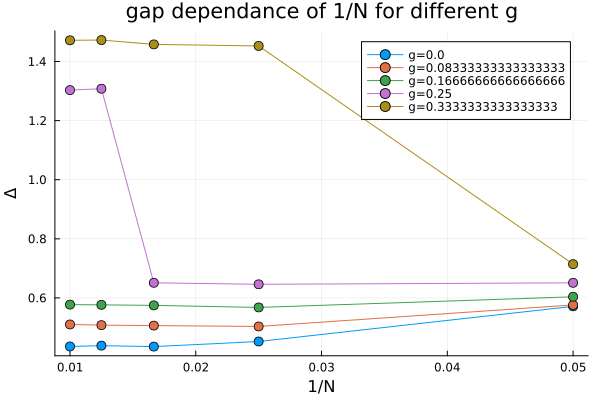

In [25]:
i=1
g=J2_arr[i]
x = 1 ./ N_arr
y = deltas_arr[i]

plot(x, y; marker = (:circle,5),title="gap dependance of 1/N for different g",label="g=$g",xlabel="1/N",ylabel= "Δ")
for i in 2:5
    g=J2_arr[i]
    y = deltas_arr[i]
    plot!(x, y ; marker = (:circle,5),label="g=$g")
end
plot!()

We get that for all J2 between 0 and 1/3 the energy gap is finite and non zero. I don't see any obvious trend to make a fit to find the energy gap though. I do suspect something is odd with the results of $g\in \{1/4,1/3\} $ and high N, maybe the ground state wasn't reached due to low number of sweeps or maximal bond dimension.

### 2.a Energy gaps between the ground states of S=0 and S=1 subspaces. For J2 between 0 and 1/3

In [26]:
N_arr= [ n for n in 20:20:100];
swp_num = 20
maxM = 100;

In [27]:
s0s1_res_arr=[]
for g in J2_arr
    push!(s0s1_res_arr,energy_gap_calc(bilinear_biquadtatic_DMRG,N_arr,g,swp_num,maxM,0,1;return_states=true))
end;

After sweep 1 energy=-26.75638798881602  maxlinkdim=9 maxerr=0.00E+00 time=0.125
After sweep 2 energy=-26.828056595029913  maxlinkdim=79 maxerr=8.78E-17 time=0.368
After sweep 3 energy=-26.83029331381671  maxlinkdim=100 maxerr=5.16E-10 time=0.653
After sweep 4 energy=-26.833623190738706  maxlinkdim=100 maxerr=1.05E-09 time=0.823
After sweep 5 energy=-26.83753390916417  maxlinkdim=100 maxerr=2.34E-09 time=1.010
After sweep 6 energy=-26.839437495110868  maxlinkdim=100 maxerr=2.69E-09 time=0.738
After sweep 7 energy=-26.839907332615596  maxlinkdim=100 maxerr=3.74E-09 time=0.819
After sweep 8 energy=-26.839972031795604  maxlinkdim=100 maxerr=5.91E-09 time=0.866
After sweep 9 energy=-26.83997807919772  maxlinkdim=100 maxerr=2.27E-09 time=0.731
After sweep 10 energy=-26.839978567153093  maxlinkdim=100 maxerr=7.26E-10 time=0.779
After sweep 11 energy=-26.839978618582453  maxlinkdim=100 maxerr=4.42E-10 time=0.752
After sweep 12 energy=-26.83997863022718  maxlinkdim=100 maxerr=3.86E-10 time=0.6

After sweep 20 energy=-82.8807333629334  maxlinkdim=100 maxerr=2.54E-10 time=3.117
After sweep 1 energy=-81.49245128185558  maxlinkdim=9 maxerr=0.00E+00 time=0.393
After sweep 2 energy=-82.36334845414164  maxlinkdim=81 maxerr=9.11E-17 time=1.447
After sweep 3 energy=-82.40453443367726  maxlinkdim=100 maxerr=9.50E-10 time=2.987
After sweep 4 energy=-82.42014219172032  maxlinkdim=100 maxerr=6.15E-10 time=2.954
After sweep 5 energy=-82.43609193451445  maxlinkdim=100 maxerr=1.70E-09 time=3.133
After sweep 6 energy=-82.86458010803855  maxlinkdim=100 maxerr=1.63E-09 time=3.235
After sweep 7 energy=-82.88067860956218  maxlinkdim=100 maxerr=8.39E-10 time=3.398
After sweep 8 energy=-82.88071545207973  maxlinkdim=100 maxerr=4.65E-10 time=3.553
After sweep 9 energy=-82.88071581446773  maxlinkdim=100 maxerr=1.22E-10 time=3.091
After sweep 10 energy=-82.88071581578306  maxlinkdim=100 maxerr=6.07E-11 time=3.348
After sweep 11 energy=-82.88071581583011  maxlinkdim=100 maxerr=6.06E-11 time=3.176
After

After sweep 18 energy=-138.9400860942461  maxlinkdim=100 maxerr=6.06E-11 time=5.119
After sweep 19 energy=-138.94008609424617  maxlinkdim=100 maxerr=6.06E-11 time=6.156
After sweep 20 energy=-138.9400860942464  maxlinkdim=100 maxerr=6.06E-11 time=5.335
After sweep 1 energy=-22.998796096796468  maxlinkdim=9 maxerr=0.00E+00 time=0.116
After sweep 2 energy=-23.046826549391092  maxlinkdim=78 maxerr=9.31E-17 time=0.501
After sweep 3 energy=-23.047100886268854  maxlinkdim=100 maxerr=8.25E-11 time=1.230
After sweep 4 energy=-23.047442836572483  maxlinkdim=100 maxerr=1.45E-10 time=1.222
After sweep 5 energy=-23.048123180033038  maxlinkdim=100 maxerr=2.27E-10 time=1.308
After sweep 6 energy=-23.049263654809963  maxlinkdim=100 maxerr=3.23E-10 time=1.295
After sweep 7 energy=-23.05039129550728  maxlinkdim=100 maxerr=5.89E-10 time=1.189
After sweep 8 energy=-23.05093750671484  maxlinkdim=100 maxerr=5.20E-10 time=1.226
After sweep 9 energy=-23.05107585292633  maxlinkdim=100 maxerr=3.37E-10 time=1.2

After sweep 16 energy=-71.31885889943842  maxlinkdim=100 maxerr=2.69E-12 time=5.522
After sweep 17 energy=-71.31885889943854  maxlinkdim=100 maxerr=2.69E-12 time=5.346
After sweep 18 energy=-71.31885889943864  maxlinkdim=100 maxerr=2.69E-12 time=5.520
After sweep 19 energy=-71.31885889943834  maxlinkdim=100 maxerr=2.69E-12 time=5.525
After sweep 20 energy=-71.31885889943857  maxlinkdim=100 maxerr=2.69E-12 time=5.456
After sweep 1 energy=-70.1351816713783  maxlinkdim=9 maxerr=0.00E+00 time=0.780
After sweep 2 energy=-70.73220725388954  maxlinkdim=80 maxerr=9.56E-17 time=1.850
After sweep 3 energy=-70.77190812763224  maxlinkdim=100 maxerr=5.61E-11 time=5.046
After sweep 4 energy=-70.79095902702919  maxlinkdim=100 maxerr=2.22E-10 time=5.085
After sweep 5 energy=-70.80229900082846  maxlinkdim=100 maxerr=2.54E-10 time=5.481
After sweep 6 energy=-71.31762469411922  maxlinkdim=100 maxerr=1.05E-09 time=5.077
After sweep 7 energy=-71.31884981410249  maxlinkdim=100 maxerr=4.78E-11 time=6.205
Aft

After sweep 14 energy=-119.59303887799537  maxlinkdim=100 maxerr=2.69E-12 time=9.640
After sweep 15 energy=-119.59303887799561  maxlinkdim=100 maxerr=2.69E-12 time=10.848
After sweep 16 energy=-119.5930388779954  maxlinkdim=100 maxerr=2.69E-12 time=10.207
After sweep 17 energy=-119.59303887799472  maxlinkdim=100 maxerr=2.69E-12 time=10.619
After sweep 18 energy=-119.59303887799578  maxlinkdim=100 maxerr=2.69E-12 time=9.955
After sweep 19 energy=-119.59303887799503  maxlinkdim=100 maxerr=2.69E-12 time=9.973
After sweep 20 energy=-119.59303887799535  maxlinkdim=100 maxerr=2.69E-12 time=9.701
After sweep 1 energy=-19.383915149749974  maxlinkdim=9 maxerr=0.00E+00 time=0.124
After sweep 2 energy=-19.409761192481984  maxlinkdim=78 maxerr=9.99E-17 time=0.518
After sweep 3 energy=-19.4097848632376  maxlinkdim=100 maxerr=2.79E-12 time=1.279
After sweep 4 energy=-19.40979438748053  maxlinkdim=100 maxerr=5.34E-12 time=1.309
After sweep 5 energy=-19.409809982056814  maxlinkdim=100 maxerr=8.13E-12 

After sweep 12 energy=-60.15873253654057  maxlinkdim=100 maxerr=1.02E-13 time=5.772
After sweep 13 energy=-60.15873253654068  maxlinkdim=100 maxerr=1.02E-13 time=5.578
After sweep 14 energy=-60.158732536540505  maxlinkdim=100 maxerr=1.02E-13 time=5.473
After sweep 15 energy=-60.15873253654057  maxlinkdim=100 maxerr=1.02E-13 time=5.675
After sweep 16 energy=-60.1587325365407  maxlinkdim=100 maxerr=1.02E-13 time=5.613
After sweep 17 energy=-60.15873253654051  maxlinkdim=100 maxerr=1.02E-13 time=5.663
After sweep 18 energy=-60.1587325365407  maxlinkdim=100 maxerr=1.02E-13 time=6.149
After sweep 19 energy=-60.15873253654062  maxlinkdim=100 maxerr=1.02E-13 time=5.480
After sweep 20 energy=-60.158732536540604  maxlinkdim=100 maxerr=1.02E-13 time=6.591
After sweep 1 energy=-59.13898872029462  maxlinkdim=9 maxerr=0.00E+00 time=0.567
After sweep 2 energy=-59.51027995447082  maxlinkdim=80 maxerr=9.22E-17 time=1.759
After sweep 3 energy=-59.545859307519486  maxlinkdim=100 maxerr=4.22E-11 time=5.1

After sweep 10 energy=-100.90777581433709  maxlinkdim=100 maxerr=1.13E-08 time=9.558
After sweep 11 energy=-100.90807304022535  maxlinkdim=100 maxerr=8.76E-12 time=9.443
After sweep 12 energy=-100.90807677653768  maxlinkdim=100 maxerr=1.26E-12 time=9.348
After sweep 13 energy=-100.90807686095486  maxlinkdim=100 maxerr=1.78E-13 time=10.918
After sweep 14 energy=-100.9080768616993  maxlinkdim=100 maxerr=1.15E-13 time=9.600
After sweep 15 energy=-100.90807686169984  maxlinkdim=100 maxerr=1.02E-13 time=9.652
After sweep 16 energy=-100.90807686170054  maxlinkdim=100 maxerr=1.02E-13 time=9.642
After sweep 17 energy=-100.9080768616999  maxlinkdim=100 maxerr=1.02E-13 time=10.557
After sweep 18 energy=-100.90807686170018  maxlinkdim=100 maxerr=1.02E-13 time=10.553
After sweep 19 energy=-100.90807686169953  maxlinkdim=100 maxerr=1.02E-13 time=11.100
After sweep 20 energy=-100.90807686169978  maxlinkdim=100 maxerr=1.02E-13 time=13.398
After sweep 1 energy=-15.930106346650668  maxlinkdim=9 maxerr=

After sweep 8 energy=-49.47049315620803  maxlinkdim=100 maxerr=1.50E-15 time=5.939
After sweep 9 energy=-49.470493156207766  maxlinkdim=100 maxerr=1.50E-15 time=5.743
After sweep 10 energy=-49.47049315620763  maxlinkdim=100 maxerr=1.50E-15 time=7.655
After sweep 11 energy=-49.47049315620803  maxlinkdim=100 maxerr=1.50E-15 time=6.979
After sweep 12 energy=-49.47049315620795  maxlinkdim=100 maxerr=1.50E-15 time=5.715
After sweep 13 energy=-49.47049315620797  maxlinkdim=100 maxerr=1.50E-15 time=6.635
After sweep 14 energy=-49.47049315620785  maxlinkdim=100 maxerr=1.50E-15 time=7.029
After sweep 15 energy=-49.47049315620783  maxlinkdim=100 maxerr=1.50E-15 time=5.623
After sweep 16 energy=-49.47049315620802  maxlinkdim=100 maxerr=1.50E-15 time=6.696
After sweep 17 energy=-49.47049315620787  maxlinkdim=100 maxerr=1.50E-15 time=5.803
After sweep 18 energy=-49.470493156207944  maxlinkdim=100 maxerr=1.50E-15 time=5.681
After sweep 19 energy=-49.47049315620797  maxlinkdim=100 maxerr=1.50E-15 tim

After sweep 6 energy=-82.34613558887528  maxlinkdim=100 maxerr=2.68E-11 time=10.572
After sweep 7 energy=-82.35086366450369  maxlinkdim=100 maxerr=2.65E-11 time=10.371
After sweep 8 energy=-82.35478444344471  maxlinkdim=100 maxerr=2.76E-11 time=9.951
After sweep 9 energy=-82.35798595563438  maxlinkdim=100 maxerr=4.01E-11 time=10.178
After sweep 10 energy=-82.36063850562482  maxlinkdim=100 maxerr=4.87E-11 time=10.302
After sweep 11 energy=-82.36274335973653  maxlinkdim=100 maxerr=4.45E-11 time=10.061
After sweep 12 energy=-82.36438933998318  maxlinkdim=100 maxerr=2.50E-11 time=9.886
After sweep 13 energy=-82.36570810280926  maxlinkdim=100 maxerr=1.76E-11 time=10.212
After sweep 14 energy=-83.0002667127027  maxlinkdim=100 maxerr=7.62E-09 time=13.062
After sweep 15 energy=-83.00033073143882  maxlinkdim=100 maxerr=6.36E-14 time=10.105
After sweep 16 energy=-83.00033192645971  maxlinkdim=100 maxerr=1.09E-14 time=10.554
After sweep 17 energy=-83.00033198478489  maxlinkdim=100 maxerr=1.05E-14

After sweep 5 energy=-39.33333331822039  maxlinkdim=100 maxerr=6.03E-16 time=5.378
After sweep 6 energy=-39.33333333254628  maxlinkdim=88 maxerr=9.99E-17 time=3.683
After sweep 7 energy=-39.33333333330261  maxlinkdim=61 maxerr=1.00E-16 time=2.021
After sweep 8 energy=-39.33333333333317  maxlinkdim=12 maxerr=9.93E-17 time=0.888
After sweep 9 energy=-39.33333333333338  maxlinkdim=2 maxerr=8.04E-17 time=0.425
After sweep 10 energy=-39.33333333333332  maxlinkdim=2 maxerr=6.15E-21 time=0.312
After sweep 11 energy=-39.333333333333336  maxlinkdim=2 maxerr=2.28E-25 time=0.397
After sweep 12 energy=-39.33333333333335  maxlinkdim=2 maxerr=8.88E-30 time=0.248
After sweep 13 energy=-39.33333333333331  maxlinkdim=2 maxerr=5.41E-30 time=0.328
After sweep 14 energy=-39.33333333333334  maxlinkdim=2 maxerr=5.23E-30 time=0.227
After sweep 15 energy=-39.333333333333314  maxlinkdim=2 maxerr=3.33E-30 time=0.238
After sweep 16 energy=-39.33333333333333  maxlinkdim=2 maxerr=1.24E-29 time=0.331
After sweep 17

After sweep 5 energy=-65.2445208995345  maxlinkdim=100 maxerr=1.10E-11 time=11.748
After sweep 6 energy=-65.25467415448001  maxlinkdim=100 maxerr=1.71E-10 time=13.046
After sweep 7 energy=-65.26124443976092  maxlinkdim=100 maxerr=7.57E-11 time=8.401
After sweep 8 energy=-65.2668976860204  maxlinkdim=100 maxerr=5.87E-11 time=5.999
After sweep 9 energy=-65.27172866114529  maxlinkdim=100 maxerr=2.65E-11 time=4.309
After sweep 10 energy=-65.2756330024334  maxlinkdim=100 maxerr=6.05E-11 time=3.538
After sweep 11 energy=-65.27877500489474  maxlinkdim=100 maxerr=8.88E-11 time=3.145
After sweep 12 energy=-65.28132871799725  maxlinkdim=100 maxerr=1.57E-10 time=3.038
After sweep 13 energy=-65.28338202535367  maxlinkdim=100 maxerr=8.53E-11 time=3.435
After sweep 14 energy=-65.28502576273677  maxlinkdim=100 maxerr=5.74E-11 time=3.199
After sweep 15 energy=-65.28634604379214  maxlinkdim=100 maxerr=8.97E-11 time=4.863
After sweep 16 energy=-65.28741062212472  maxlinkdim=100 maxerr=5.25E-11 time=3.43

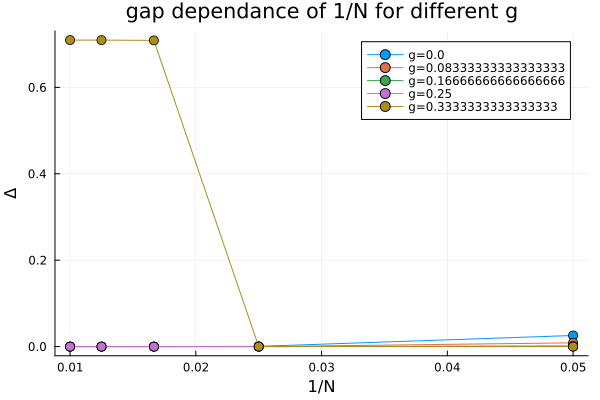

In [28]:
i=1
g=J2_arr[i]
x = 1 ./ N_arr
y = s0s1_res_arr[i][1]

plot(x, y; marker = (:circle,5),title="gap dependance of 1/N for different g",label="g=$g",xlabel="1/N",ylabel= "Δ")
for i in 2:5
    g=J2_arr[i]
    y = s0s1_res_arr[i][1]
    plot!(x, y ; marker = (:circle,5),label="g=$g")
end
plot!()

Above, the plot indicates a deviation from the expected behavior for g=1/3 (even when the sweep_num was increased to 200 instead of 100, which did solve the g=1/4 problem). I suspect that as We get close to g=1/3 the computation of the ground state is requiering more sweeps for the larger sizes of the system.
Below are the plots with g$\neq 1/3$

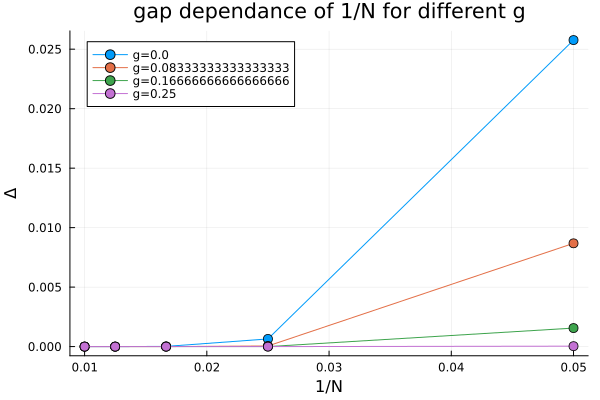

In [53]:
i=1
g=J2_arr[i]
x = 1 ./ N_arr
y = s0s1_res_arr[i][1]

plot(x, y; marker = (:circle,5),title="gap dependance of 1/N for different g",label="g=$g",xlabel="1/N",ylabel= "Δ")
for i in 2:4
    g=J2_arr[i]
    y = s0s1_res_arr[i][1]
    plot!(x, y ; marker = (:circle,5),label="g=$g")
end
plot!()

For some unknown reason, plotting with logscale breaks the Plots module which forces me to restart the kernel and do the calculations from the tops, which is not very nice because the calculation takes very long time.. The trend seems to follow an exponential decay as N increases.

### 2.b Local expectation value of Sz along the chain

In [29]:
function plot_and_talk_about_Sz_expectation(expectation_Sz,g,sum_near_edges::Int64)
    p=plot(expectation_Sz,xlabel="i",ylabel="⟨Sz⟩",title="g=$g ⟨Sz⟩'s across the chain")
    left=expectation_Sz[1]
    right=expectation_Sz[end]
    sum_left=sum([expectation_Sz[i] for i in 1:sum_near_edges])
    sum_right=sum([expectation_Sz[end-i+1] for i in 1:sum_near_edges])
    println("For g=$g")
    println("The spin values at the edges are- Left=$left Right=$right")
    println("The spin sum of $sum_near_edges nearest to the edges are- Left=$sum_left Right=$sum_right")
    return p
end;

In [46]:
sum_near_edges=Int64(50)

50

For g=0.0
The spin values at the edges are- Left=0.5320383971629347 Right=0.5320383958382695
The spin sum of 50 nearest to the edges are- Left=0.49999999995507927 Right=0.5000000000449272


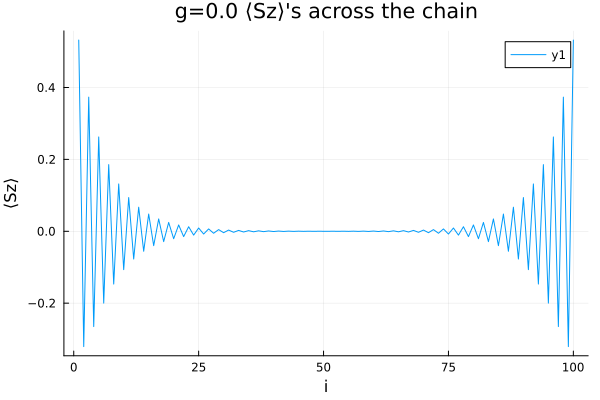

In [47]:
i=1
plot(plot_and_talk_about_Sz_expectation(expect(s0s1_res_arr[i][3][end], "Sz"),J2_arr[i],sum_near_edges))

For g=0.08333333333333333
The spin values at the edges are- Left=0.5825080420822476 Right=0.5825080420469011
The spin sum of 50 nearest to the edges are- Left=0.4999999999988456 Right=0.5000000000011539


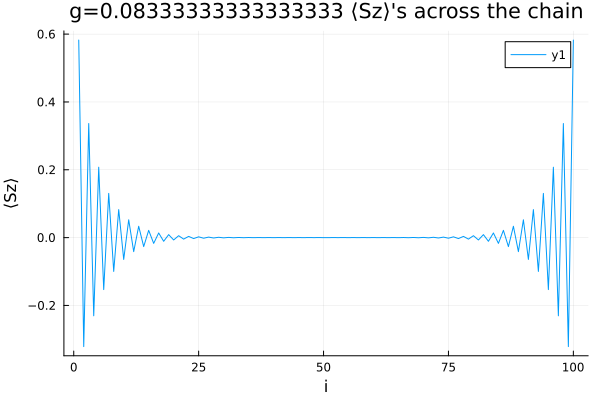

In [48]:
i=2
plot(plot_and_talk_about_Sz_expectation(expect(s0s1_res_arr[i][3][end], "Sz"),J2_arr[i],sum_near_edges))

For g=0.16666666666666666
The spin values at the edges are- Left=0.625159842888251 Right=0.6251598428835603
The spin sum of 50 nearest to the edges are- Left=0.500000000000034 Right=0.49999999999996564


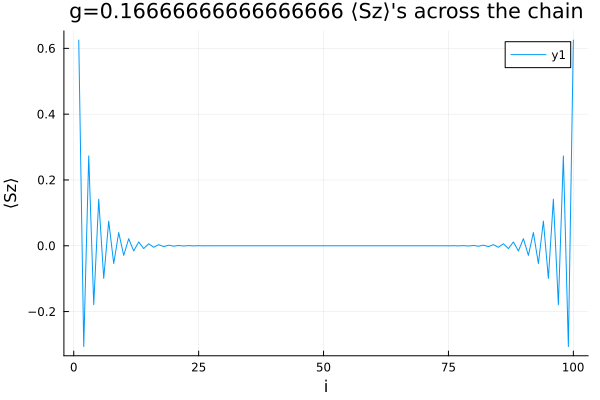

In [49]:
i=3
plot(plot_and_talk_about_Sz_expectation(expect(s0s1_res_arr[i][3][end], "Sz"),J2_arr[i],sum_near_edges))

For g=0.25
The spin values at the edges are- Left=0.6552035577897537 Right=0.6552035577899775
The spin sum of 50 nearest to the edges are- Left=0.4999999999999544 Right=0.5000000000000355


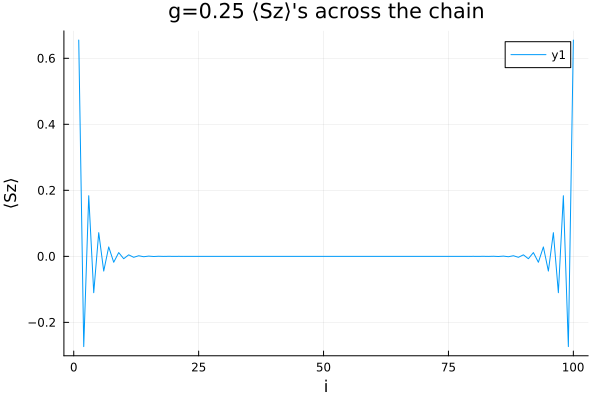

In [50]:
i=4
plot(plot_and_talk_about_Sz_expectation(expect(s0s1_res_arr[i][3][end], "Sz"),J2_arr[i],sum_near_edges))

For gs up to 1/4, the sums of the spins up to the middle of the chain is 1/2 in each of the sides.
The spins exactly at the edges are close to 2/3.

For g=0.3333333333333333
The spin values at the edges are- Left=0.6654964246918822 Right=-0.6666666666666708
The spin sum of 50 nearest to the edges are- Left=1.4999999999920317 Right=-0.49999999999203343


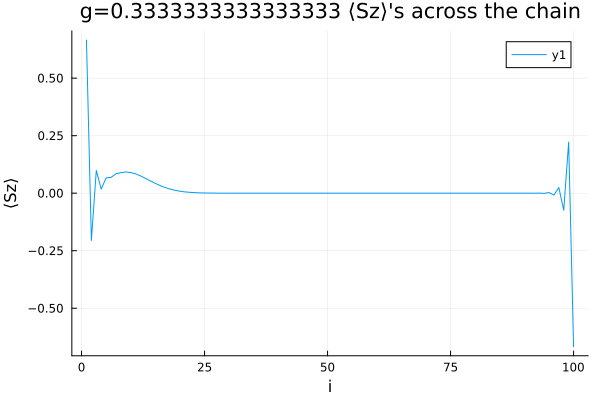

In [51]:
i=5
plot(plot_and_talk_about_Sz_expectation(expect(s0s1_res_arr[i][3][end], "Sz"),J2_arr[i],sum_near_edges))

for g=1/3 I haven't managed to reach the ground state with the parameters used for the other gs, it is appearent here as the state is not symmetric, unlike the states found for the other gs.